## Training

The Training was completed in a separate GPU environment with the following parameters:

In [ ]:
### training ###


# # hidden_units = 32

# !python main.py \
# --dataset=beauty23 \
# --train_dir=hidden32 \
# --hidden_units=32 \
# --maxlen=50 \
# --dropout_rate=0.5 \
# --device=cuda


# # hidden_units = 64

# !python main.py \
# --dataset=beauty23 \
# --train_dir=hidden64 \
# --hidden_units=64 \
# --maxlen=50 \
# --dropout_rate=0.5 \
# --device=cuda


# # hidden_units = 128

# !python main.py \
# --dataset=beauty23 \
# --train_dir=hidden128 \
# --hidden_units=128 \
# --maxlen=50 \
# --dropout_rate=0.5 \
# --device=cuda

## Testing

The below cells will test the trained SASRec models on the test set.

In [11]:
# test SASRec with hidden_units=32

!python main.py \
--device=cpu \
--dataset=beauty23 \
--train_dir=hidden32 \
--state_dict_path='beauty23_hidden32/SASRec.epoch=1000.lr=0.001.layer=2.head=1.hidden=32.maxlen=50.pth' \
--inference_only=true \
--maxlen=50 \
--hidden_units=32 \
--dropout_rate=0.5


average sequence length: 7.42
..........test (NDCG@10: 0.3146, HR@5: 0.3644, HR@10: 0.4598)
Done


In [12]:
# test SASRec with hidden_units=64

!python main.py \
--device=cpu \
--dataset=beauty23 \
--train_dir=hidden64 \
--state_dict_path='beauty23_hidden64/SASRec.epoch=1000.lr=0.001.layer=2.head=1.hidden=64.maxlen=50.pth' \
--inference_only=true \
--maxlen=50 \
--hidden_units=64 \
--dropout_rate=0.5


average sequence length: 7.42
..........test (NDCG@10: 0.2932, HR@5: 0.3347, HR@10: 0.4151)
Done


In [10]:
# test SASRec with hidden_units=128

!python main.py \
--device=cpu \
--dataset=beauty23 \
--train_dir=hidden128 \
--state_dict_path='beauty23_hidden128/SASRec.epoch=1000.lr=0.001.layer=2.head=1.hidden=128.maxlen=50.pth' \
--inference_only=true \
--maxlen=50 \
--hidden_units=128 \
--dropout_rate=0.5


average sequence length: 7.42
..........test (NDCG@10: 0.2804, HR@5: 0.3128, HR@10: 0.3893)
Done


### Results

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
dims = [32, 64, 128]
ndcg10 = [0.3146, 0.2932, 0.2804]
hr5 = [0.3644, 0.3347, 0.3128]
hr10 = [0.4598, 0.4151, 0.3893]

metrics = pd.DataFrame()
metrics['dim'] = dims
metrics = metrics.set_index('dim')
metrics['NDCG@10'] = ndcg10
metrics['HR@5'] = hr5
metrics['HR@10'] = hr10
metrics

,NDCG@10,HR@5,HR@10
dim,,,
32,0.3146,0.3644,0.4598
64,0.2932,0.3347,0.4151
128,0.2804,0.3128,0.3893


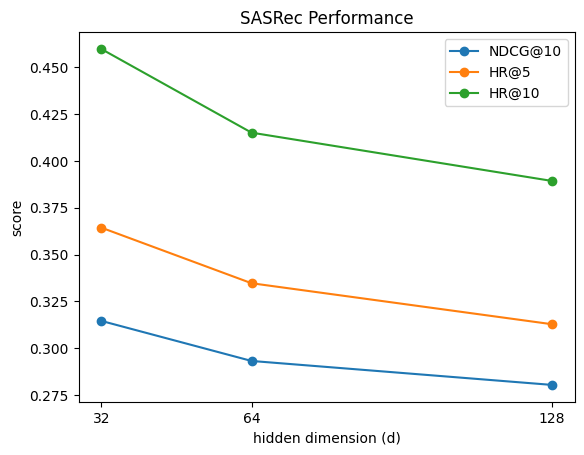

In [21]:
plt.plot(metrics.index, 'NDCG@10', data=metrics, marker='o', label='NDCG@10')
plt.plot(metrics.index, 'HR@5', data=metrics, marker='o', label='HR@5')
plt.plot(metrics.index, 'HR@10', data=metrics, marker='o', label='HR@10')
plt.title('SASRec Performance')
plt.xticks(metrics.index)
plt.xlabel('hidden dimension (d)')
plt.ylabel('score')
plt.legend()
plt.show()